# moment predictions

In [2]:
#Import
import sys
sys.path.append("../lib")
import basicfunc as func
import plotlib as plib

import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = 12, 16
import pymaster as nmt
import healpy as hp
import pysm3
import pysm3.units as u
import simu_lib as sim
import scipy.stats as st

def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

def compute_cl(mapd,mask,b):
    fa1 = nmt.NmtField(mask, (mapd)*1,purify_e=False, purify_b=True)
    wsp = nmt.NmtWorkspace()
    wsp.compute_coupling_matrix(fa1, fa1, b)
    return compute_master(fa1,fa1,wsp)        

def compute_cross_cl(mapd1,mapd2,mask,b):
    fa1 = nmt.NmtField(mask, (mapd1)*1,purify_e=False, purify_b=True)
    fa2 = nmt.NmtField(mask, (mapd2)*1,purify_e=False, purify_b=True)
    wsp = nmt.NmtWorkspace()
    wsp.compute_coupling_matrix(fa1, fa2, b)
    return compute_master(fa1,fa2,wsp) 

def plotmed(ell,label,res,color='darkblue',marker="D",show=True,legend=''):
    """
    Plot median and median absolute deviation of best-fits as a function of ell
    :ell: bandpower array
    :label: string indicating the name of the quantity
    :color: color of the plot
    :marker: marker of the plot
    :show: show the plot
    legend: legend to add to the plot
    """
    ellbound=ell.shape[0]
    name={'A':r'$A^d$','beta':r'$\beta^d$','temp':r'$T^d$','beta_s':r'$\beta^s$','A_s':r'$A^s$','A_sd':r'$A^{sd}$','r':r'$\hat{r}$','X2red':r'$\chi^2$','Aw1b':r'$\mathcal{D}_\ell^{A\times\omega_1^{\beta}}$','Aw1t':r'$\mathcal{D}_\ell^{A\times\omega_1^{T}}$','Asw1bs':r'$\mathcal{D}_\ell^{A_s\times\omega_1^{\beta^s}}$','w1bw1s':r'$\mathcal{D}_\ell^{\omega_1^{\beta^d}\times\omega_1^{\beta^s}}$','w1sw1T':r'$\mathcal{D}_\ell^{\omega_1^{T^d}\times\omega_1^{\beta^s}}$','w1bw1b':r'$\mathcal{D}_\ell^{\omega_1^\beta\times\omega_1^\beta}$','w1tw1t':r'$\mathcal{D}_\ell^{\omega_1^T\times\omega_1^T}$','w1bw1t':r'$\mathcal{D}_\ell^{\omega_1^\beta\times\omega_1^T}$','w1bsw1bs':r'$\mathcal{D}_\ell^{\omega_1^{\beta^s}\times\omega_1^{\beta^s}}$', 'Asw1b':r'$\mathcal{D}_\ell^{A_s\times\omega_1^{\beta}}$','Asw1t':r'$\mathcal{D}_\ell^{A_s\times\omega_1^{T}}$','Adw1s':r'$\mathcal{D}_\ell^{A\times\omega_1^{\beta^s}}$'}
    edgecolor="#80AAF3"
    plt.errorbar(ell,np.median(res[label],axis=1)[:ellbound],yerr=st.median_abs_deviation(res[label],axis=1)[:ellbound],c=color,fmt=marker,linestyle='',label=legend)
    plt.scatter(ell,np.median(res[label],axis=1)[:ellbound],s=175,c=color,marker=marker,edgecolor=edgecolor)
    plt.ylabel(name[label],fontsize=20)
    plt.xlabel(r"$\ell$",fontsize=20)
    plt.legend()
    plt.tight_layout()
    if show==True:
        plt.show()


In [3]:
#choose frequency range

dusttype=1
syncrotype=0
instr= 'LiteBIRD'
nside=64
scale=10
fsky=0.7
Nlbin = 10
lmax = nside*3-1

if fsky==1:
    mask = np.ones(hp.nside2npix(nside))
else:
    mask = hp.read_map("../masks/mask_fsky%s_nside%s_aposcale%s.npy"%(fsky,nside,scale))

b = nmt.bins.NmtBin(nside=nside,lmax=lmax,nlb=Nlbin)
leff = b.get_effective_ells()

if instr=='Planck':
    freq=np.array([100,143,217,353])
if instr=='LiteBIRD':
    freq=np.array([ 40.,  50.,  60.,  68.,  78.,  89., 100., 119., 140., 166., 195.,235., 280., 337., 402.])

sky = pysm3.Sky(nside=512, preset_strings=['d%s'%(dusttype),'s%s'%(syncrotype)])
skyd = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype])
skys = pysm3.Sky(nside=512, preset_strings=['s%s'%syncrotype])
dust = skyd.components[0]
sync= skys.components[0]
betamap =dust.mbb_index.value
tempmap=dust.mbb_temperature.value
betasmap =sync.pl_index.value
nu0d=dust.freq_ref_P.value
nu0s=sync.freq_ref_P.value

skyrefd = skyd.get_emission(nu0d * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0d*u.GHz)).value
skyrefs = skys.get_emission(nu0s * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0s*u.GHz)).value

model= np.array([sky.get_emission(freq[f] * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq[f]*u.GHz)).value for f in range(len(freq))])

In [4]:
skyrefcpxd=skyrefd[1]+1j*skyrefd[2]
skyrefcpxs=skyrefs[1]+1j*skyrefs[2]
betabar= 1.54
tempbar=20
betasbar=-3

In [5]:
mom1b = skyrefcpxd*(betamap-betabar)
mom2b = skyrefcpxd*(betamap-betabar)**2
mom1t = skyrefcpxd*(tempmap-tempbar)
mom2t = skyrefcpxd*(tempmap-tempbar)**2
mom2bt= skyrefcpxd*(tempmap-tempbar)*(betamap-betabar)
mom1bs = skyrefcpxs*(betasmap-betasbar)
mom2bs = skyrefcpxs*(betasmap-betasbar)

In [6]:
def getmom_downgr(mom):
    momarr=np.array([np.zeros(hp.nside2npix(512)),mom.real,mom.imag])
    momdg=sim.downgrade_map(momarr,nside_in=512,nside_out=nside)
    return momdg
def get_dl_bb_mom(map1,map2):
    return leff*(leff+1)*compute_cross_cl(getmom_downgr(map1)[1:],getmom_downgr(map2)[1:],mask,b)[3]/2/np.pi

findfont: Font family ['Comics San'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Comics San'] not found. Falling back to DejaVu Sans.


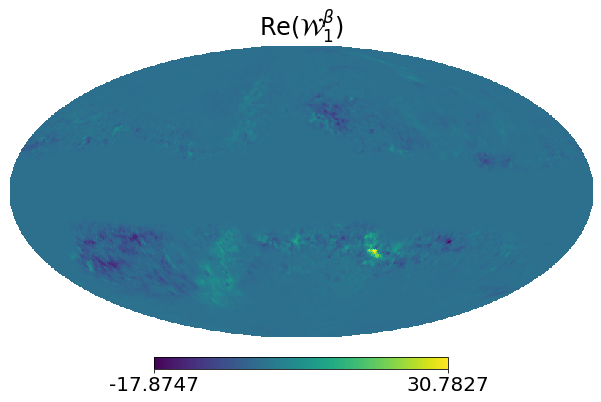

In [7]:
hp.mollview(getmom_downgr(mom1b)[1]*mask,title=r'${\rm Re}(\mathcal{W}_1^\beta)$')

In [8]:
Ad= get_dl_bb_mom(skyrefcpxd,skyrefcpxd)
As= get_dl_bb_mom(skyrefcpxs,skyrefcpxs)
Asd=get_dl_bb_mom(skyrefcpxd,skyrefcpxs)
w1bw1b = get_dl_bb_mom(mom1b,mom1b)
Aw1b= get_dl_bb_mom(skyrefcpxd,mom1b)
Aw1t=get_dl_bb_mom(skyrefcpxd,mom1t)
w1bw1t=get_dl_bb_mom(mom1b,mom1t)
w1tw1t=get_dl_bb_mom(mom1t,mom1t)
Asw1b= get_dl_bb_mom(skyrefcpxs,mom1b)
Asw1t= get_dl_bb_mom(skyrefcpxs,mom1t)
Aw2b= get_dl_bb_mom(skyrefcpxd,mom2b)
w1bw2b= get_dl_bb_mom(mom1b,mom2b)
w2bw2b= get_dl_bb_mom(mom2b,mom2b)

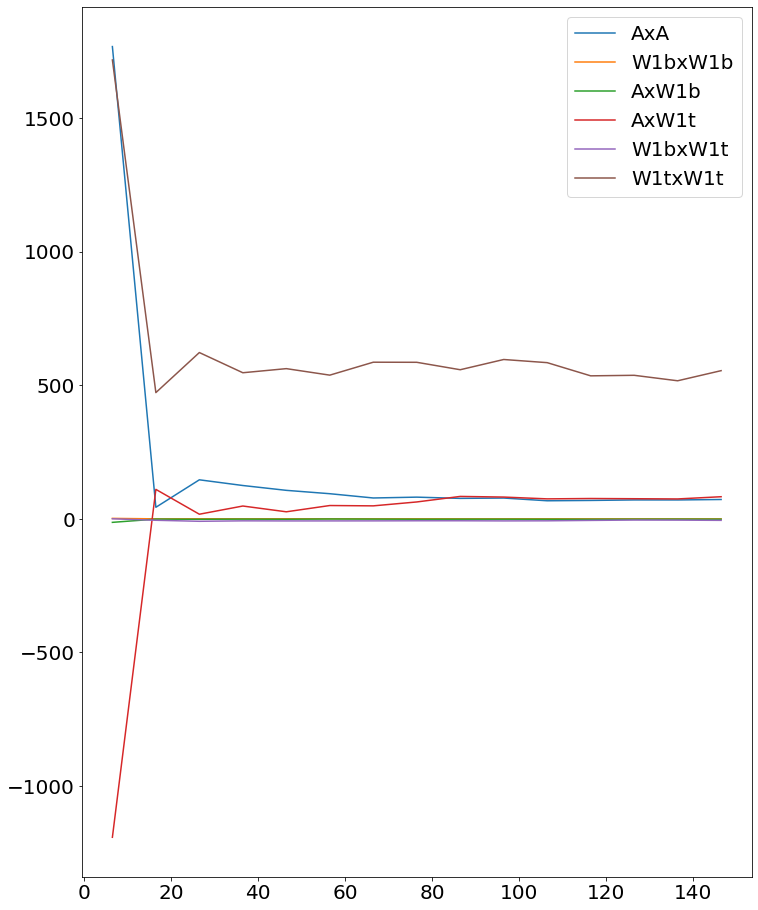

In [9]:
plt.plot(leff[:15],Ad[:15],label='AxA')
plt.plot(leff[:15],w1bw1b[:15],label='W1bxW1b')
plt.plot(leff[:15],Aw1b[:15],label='AxW1b')
plt.plot(leff[:15],Aw1t[:15],label='AxW1t')
plt.plot(leff[:15],w1bw1t[:15],label='W1bxW1t')
plt.plot(leff[:15],w1tw1t[:15],label='W1txW1t')
#plt.plot(leff[:15],get_dl_bb_mom(mom2b,mom2b)[:15],label='W2bxW2b')
#plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,mom2b)[:15],label='AxW2b')
#plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,mom2t)[:15],label='AxW2t')
#plt.plot(leff[:15],get_dl_bb_mom(mom2b,mom2t)[:15],label='W2bxW2t')
#plt.plot(leff[:15],get_dl_bb_mom(mom2t,mom2t)[:15],label='W2txW2t')
#plt.plot(leff[:15],get_dl_bb_mom(mom2bt,mom2bt)[:15],label='W2btxW2bt')
plt.legend()

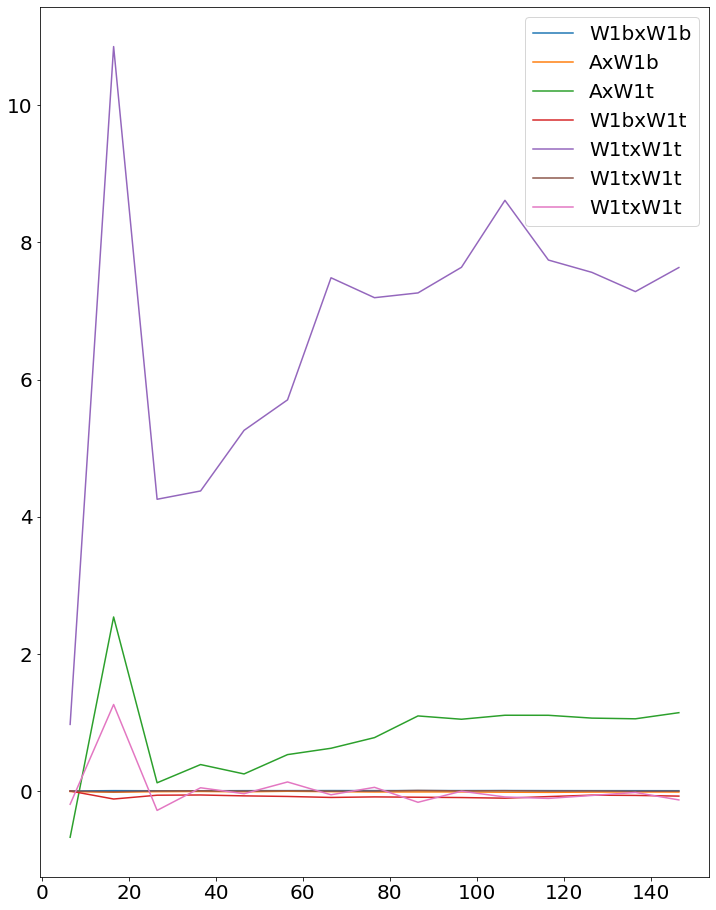

In [27]:
plt.plot(leff[:15],w1bw1b[:15]/Ad[:15],label='W1bxW1b')
plt.plot(leff[:15],Aw1b[:15]/Ad[:15],label='AxW1b')
plt.plot(leff[:15],Aw1t[:15]/Ad[:15],label='AxW1t')
plt.plot(leff[:15],w1bw1t[:15]/Ad[:15],label='W1bxW1t')
plt.plot(leff[:15],w1tw1t[:15]/Ad[:15],label='W1txW1t')
plt.plot(leff[:15],Asw1b[:15]/np.sqrt(Ad[:15]*As[:15]),label='W1txW1t')
plt.plot(leff[:15],Asw1t[:15]/np.sqrt(Ad[:15]*As[:15]),label='W1txW1t')

#plt.plot(leff[:15],get_dl_bb_mom(mom2b,mom2b)[:15],label='W2bxW2b')
#plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,mom2b)[:15],label='AxW2b')
#plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,mom2t)[:15],label='AxW2t')
#plt.plot(leff[:15],get_dl_bb_mom(mom2b,mom2t)[:15],label='W2bxW2t')
#plt.plot(leff[:15],get_dl_bb_mom(mom2t,mom2t)[:15],label='W2txW2t')
#plt.plot(leff[:15],get_dl_bb_mom(mom2bt,mom2bt)[:15],label='W2btxW2bt')
plt.legend()

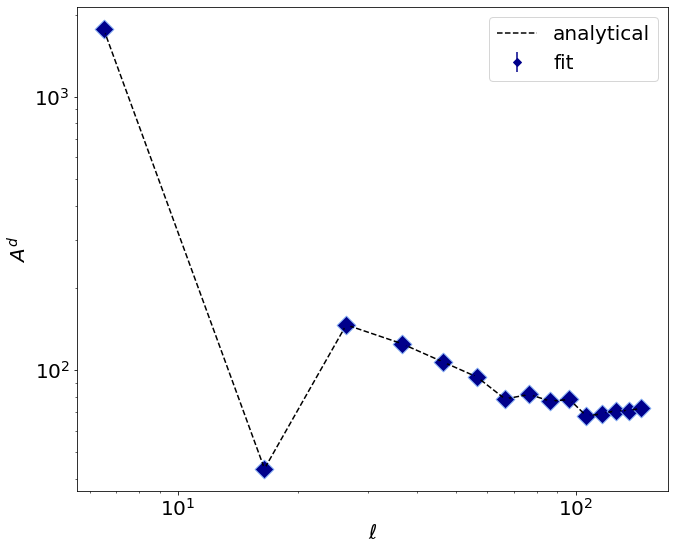

In [11]:
res=np.load('../Best-fits/results_d%ss%s_0.7_ds_o1bt_fix1.npy'%(dusttype,syncrotype),allow_pickle=True).item()
plt.figure(figsize=(10,8))
plotmed(leff[:15],'A',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],Ad[:15],c='k',linestyle='--',label='analytical')
plt.loglog()
plt.legend()
plt.show()

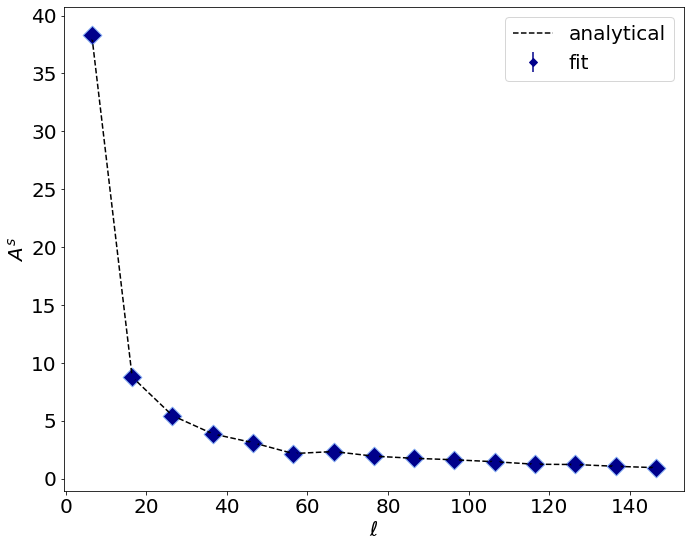

In [12]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'A_s',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],As[:15],c='k',linestyle='--',label='analytical')
#plt.loglog()
plt.legend()
plt.show()

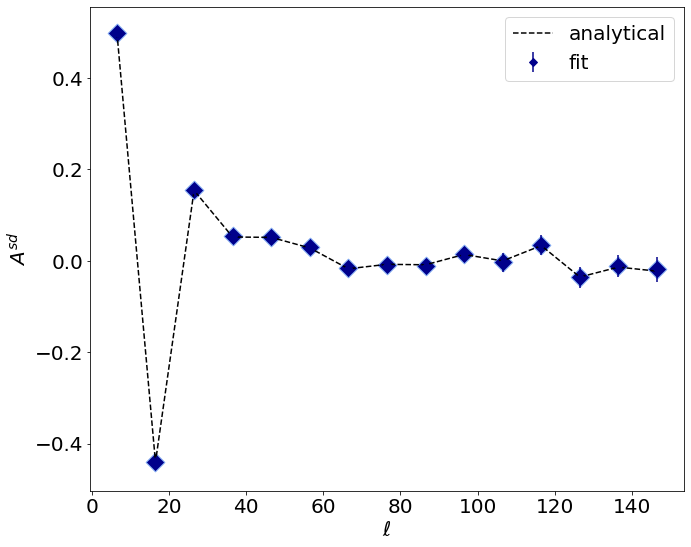

In [13]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'A_sd',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],Asd[:15]/np.sqrt(abs(Ad[:15]*As[:15])),c='k',linestyle='--',label='analytical')
#plt.loglog()
plt.legend()
plt.show()

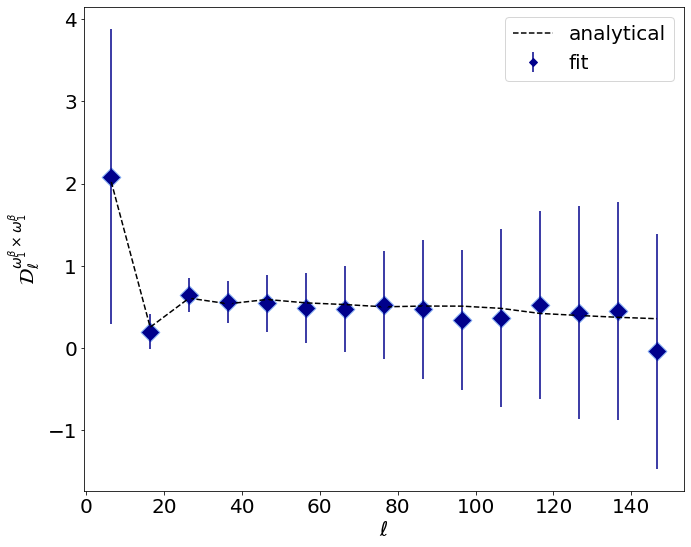

In [14]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'w1bw1b',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],w1bw1b[:15],c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

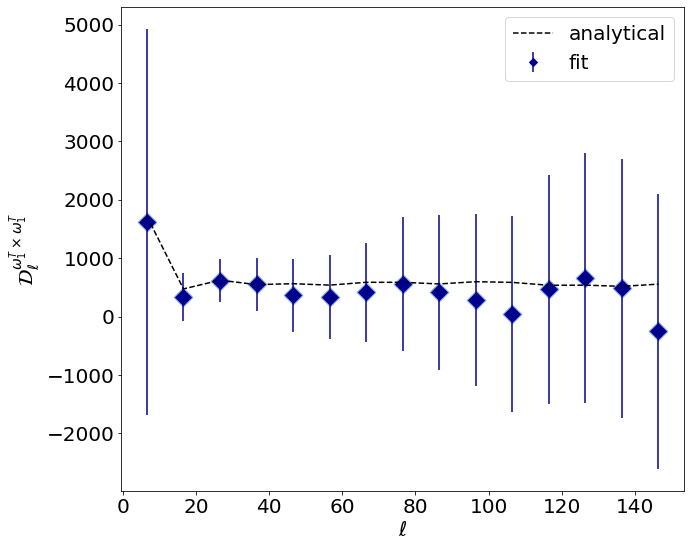

In [15]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'w1tw1t',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15], w1tw1t[:15],c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

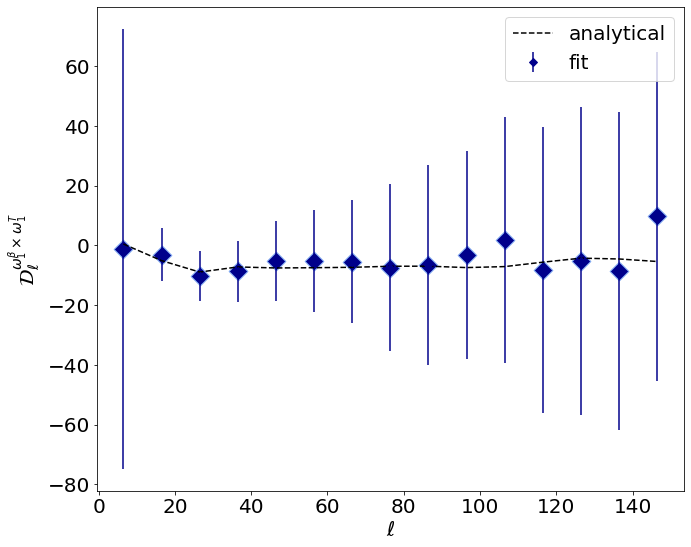

In [16]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'w1bw1t',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],w1bw1t[:15],c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

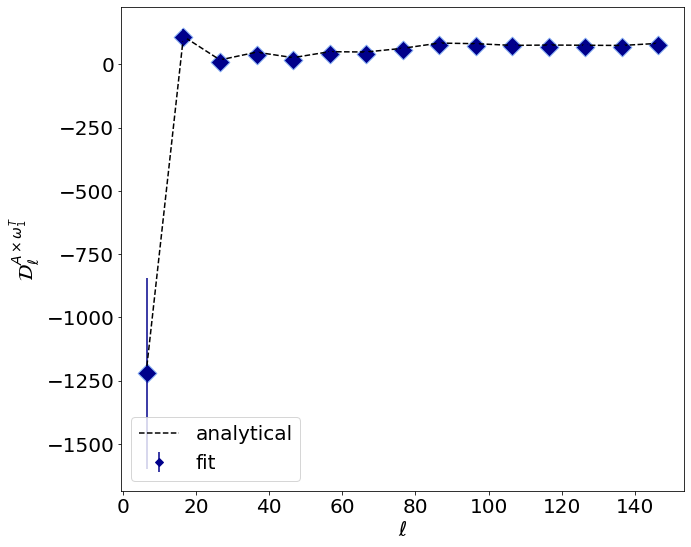

In [17]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'Aw1t',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],Aw1t[:15],c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

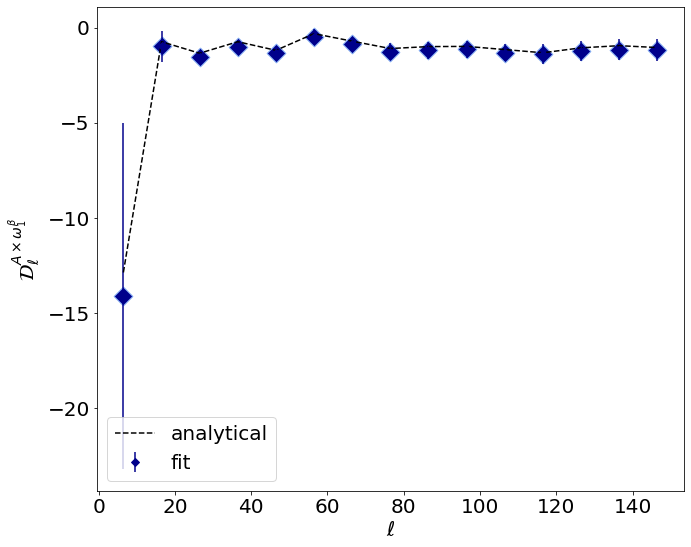

In [18]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'Aw1b',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],Aw1b[:15],c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

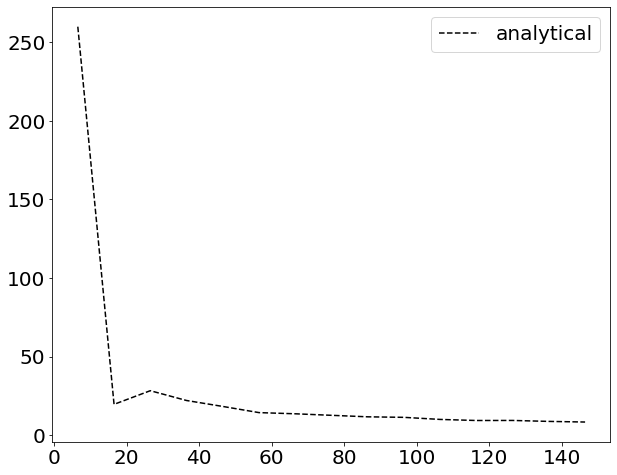

In [28]:
plt.figure(figsize=(10,8))
plt.plot(leff[:15],np.sqrt(abs(Ad[:15]*As[:15])),c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

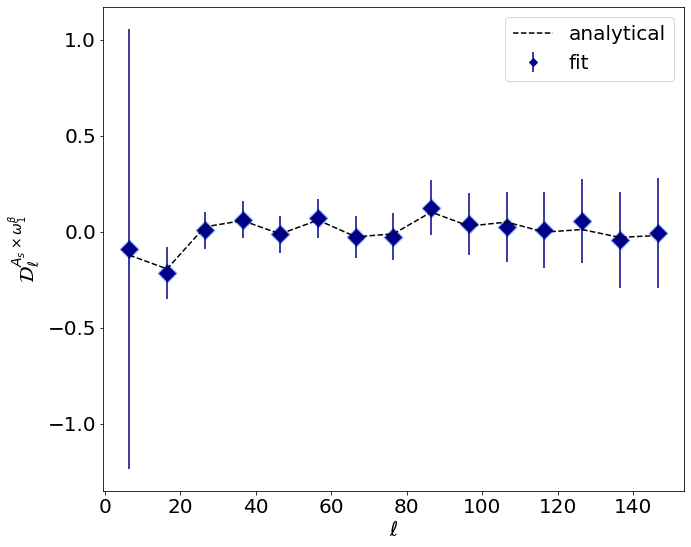

In [19]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'Asw1b',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],Asw1b[:15],c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

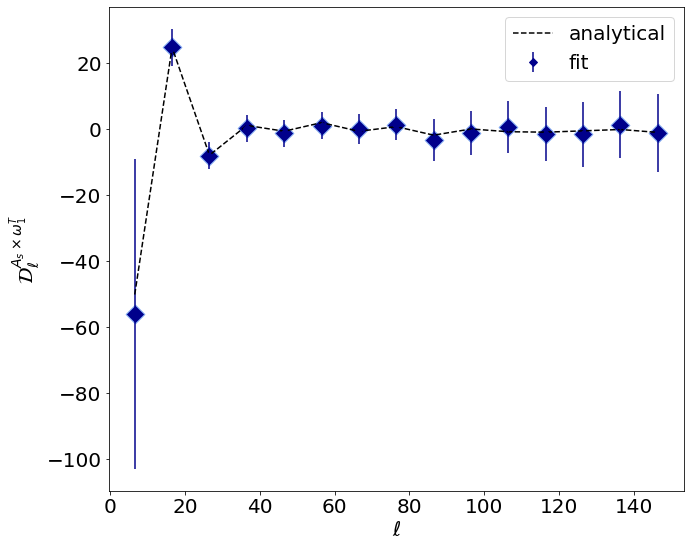

In [20]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'Asw1t',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],Asw1t[:15],c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

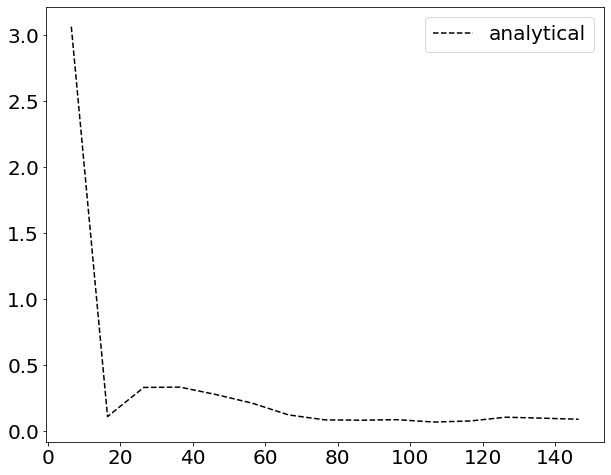

In [49]:
plt.figure(figsize=(10,8))
plt.plot(leff[:15],Aw2b[:15],c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

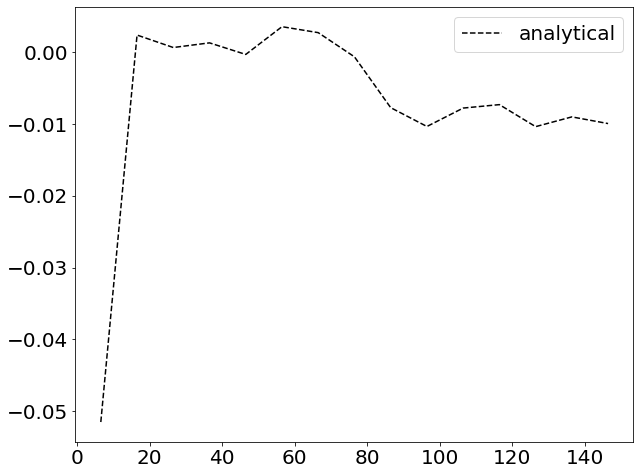

In [50]:
plt.figure(figsize=(10,8))
plt.plot(leff[:15],w1bw2b[:15],c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

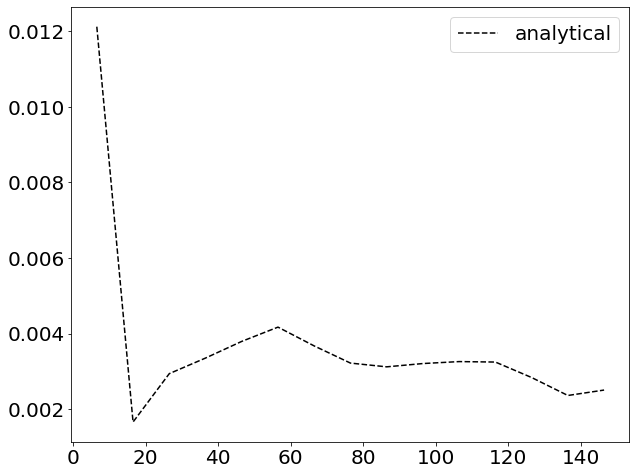

In [51]:
plt.figure(figsize=(10,8))
plt.plot(leff[:15],w2bw2b[:15],c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

In [38]:
Nell=len(leff[:15])
p=[Ad[:Nell], betabar*np.ones(Nell),tempbar*np.ones(Nell),As[:Nell],betasbar*np.ones(Nell),Asd[:Nell]/np.sqrt(As[:Nell]*Ad[:Nell]),Aw1b[:Nell],w1bw1b[:Nell],Aw1t[:Nell],w1bw1t[:Nell],w1tw1t[:Nell],Asw1b[:Nell],Asw1t[:Nell], Aw2b[:Nell], w1bw2b[:Nell], w2bw2b[:Nell]]

def modelmomo1(nu,p):
    nu_i=nu
    nu_j=nu
    nuref=353
    nurefs=23
    ampl = func.mbb_uK(nu_i,p[1],p[2])*func.mbb_uK(nu_j,p[1],p[2])
    sync= p[3]*func.PL_uK(nu_i,p[4])*func.PL_uK(nu_j,p[4])
    normcorr= np.sqrt(abs(p[0]*p[3]))
    crossdustsync= p[5]*normcorr*(func.mbb_uK(nu_i,p[1],p[2])*func.PL_uK(nu_j,p[4])+ func.PL_uK(nu_i,p[4])*func.mbb_uK(nu_j,p[1],p[2]))#/(func.PL_uK(nurefs,p[4])*func.mbb_uK(nuref,p[1],p[2]))
    lognui = np.log(nu_i/nuref)
    lognuj = np.log(nu_j/nuref)
    lognuis = np.log(nu_i/nurefs)
    lognujs = np.log(nu_j/nurefs)
    dx0 = func.dmbbT(nuref,p[2])
    dxi = func.dmbbT(nu_i,p[2])
    dxj = func.dmbbT(nu_j,p[2])
    temp = ampl * (p[0]+ (lognui+lognuj) * p[6]+ lognui*lognuj * p[7])
    temp2 = ampl*((dxi+dxj-2*dx0)*p[8]+(lognuj*(dxi-dx0)+lognui*(dxj-dx0))*p[9]+(dxi-dx0)*(dxj-dx0)*p[10])
    crossdustsync2 = p[11]*(func.mbb_uK(nu_i,p[1],p[2],nu0=nuref)*lognui*func.PL_uK(nu_j,p[4],nu0=nurefs)+ func.PL_uK(nu_i,p[4],nu0=nurefs)*func.mbb_uK(nu_j,p[1],p[2],nu0=nuref)*lognuj)
    crossdustsync3 = p[12]*(func.mbb_uK(nu_i,p[1],p[2],nu0=nuref)*(dxi-dx0)*func.PL_uK(nu_j,p[4],nu0=nurefs)+ func.PL_uK(nu_i,p[4],nu0=nurefs)*func.mbb_uK(nu_j,p[1],p[2],nu0=nuref)*(dxj-dx0))
    model = temp + temp2 + sync + crossdustsync + crossdustsync2 + crossdustsync3
    return model

def modelmomo2(nu,p):
    nu_i=nu
    nu_j=nu
    nuref=353
    nurefs=23
    ampl = func.mbb_uK(nu_i,p[1],p[2])*func.mbb_uK(nu_j,p[1],p[2])
    sync= p[3]*func.PL_uK(nu_i,p[4])*func.PL_uK(nu_j,p[4])
    normcorr= np.sqrt(abs(p[0]*p[3]))
    crossdustsync= p[5]*normcorr*(func.mbb_uK(nu_i,p[1],p[2])*func.PL_uK(nu_j,p[4])+ func.PL_uK(nu_i,p[4])*func.mbb_uK(nu_j,p[1],p[2]))#/(func.PL_uK(nurefs,p[4])*func.mbb_uK(nuref,p[1],p[2]))
    lognui = np.log(nu_i/nuref)
    lognuj = np.log(nu_j/nuref)
    lognuis = np.log(nu_i/nurefs)
    lognujs = np.log(nu_j/nurefs)
    dx0 = func.dmbbT(nuref,p[2])
    dxi = func.dmbbT(nu_i,p[2])
    dxj = func.dmbbT(nu_j,p[2])
    temp = ampl * (p[0]+ (lognui+lognuj) * p[6]+ lognui*lognuj * p[7])
    temp2 = ampl*((dxi+dxj-2*dx0)*p[8]+(lognuj*(dxi-dx0)+lognui*(dxj-dx0))*p[9]+(dxi-dx0)*(dxj-dx0)*p[10])
    crossdustsync2 = p[11]*(func.mbb_uK(nu_i,p[1],p[2],nu0=nuref)*lognui*func.PL_uK(nu_j,p[4],nu0=nurefs)+ func.PL_uK(nu_i,p[4],nu0=nurefs)*func.mbb_uK(nu_j,p[1],p[2],nu0=nuref)*lognuj)
    crossdustsync3 = p[12]*(func.mbb_uK(nu_i,p[1],p[2],nu0=nuref)*(dxi-dx0)*func.PL_uK(nu_j,p[4],nu0=nurefs)+ func.PL_uK(nu_i,p[4],nu0=nurefs)*func.mbb_uK(nu_j,p[1],p[2],nu0=nuref)*(dxj-dx0))
    temp3 = ampl * ((lognui**2+lognuj**2)*p[14]/2+ (lognui*lognuj**2 +lognui**2*lognuj) * p[14]/2+ (lognui*lognuj)**2* p[15]/4)
    model = temp + temp2 + temp3+ sync + crossdustsync + crossdustsync2 + crossdustsync3
    return model

def modelmomo1beta(nu,p):
    nu_i=nu
    nu_j=nu
    nuref=353
    nurefs=23
    ampl = func.mbb_uK(nu_i,p[1],p[2])*func.mbb_uK(nu_j,p[1],p[2])
    sync= p[3]*func.PL_uK(nu_i,p[4])*func.PL_uK(nu_j,p[4])
    normcorr= np.sqrt(abs(p[0]*p[3]))
    crossdustsync= p[5]*normcorr*(func.mbb_uK(nu_i,p[1],p[2])*func.PL_uK(nu_j,p[4])+ func.PL_uK(nu_i,p[4])*func.mbb_uK(nu_j,p[1],p[2]))#/(func.PL_uK(nurefs,p[4])*func.mbb_uK(nuref,p[1],p[2]))
    lognui = np.log(nu_i/nuref)
    lognuj = np.log(nu_j/nuref)
    lognuis = np.log(nu_i/nurefs)
    lognujs = np.log(nu_j/nurefs)
    temp = ampl * (p[0]+ (lognui+lognuj) * p[6]+ lognui*lognuj * p[7])
    crossdustsync2 = p[11]*(func.mbb_uK(nu_i,p[1],p[2],nu0=nuref)*lognui*func.PL_uK(nu_j,p[4],nu0=nurefs)+ func.PL_uK(nu_i,p[4],nu0=nurefs)*func.mbb_uK(nu_j,p[1],p[2],nu0=nuref)*lognuj)
    model = temp  + sync + crossdustsync + crossdustsync2 
    return model

def modelmomo1temp(nu,p):
    nu_i=nu
    nu_j=nu
    nuref=353
    nurefs=23
    ampl = func.mbb_uK(nu_i,p[1],p[2])*func.mbb_uK(nu_j,p[1],p[2])
    sync= p[3]*func.PL_uK(nu_i,p[4])*func.PL_uK(nu_j,p[4])
    normcorr= np.sqrt(abs(p[0]*p[3]))
    crossdustsync= p[5]*normcorr*(func.mbb_uK(nu_i,p[1],p[2])*func.PL_uK(nu_j,p[4])+ func.PL_uK(nu_i,p[4])*func.mbb_uK(nu_j,p[1],p[2]))#/(func.PL_uK(nurefs,p[4])*func.mbb_uK(nuref,p[1],p[2]))
    dx0 = func.dmbbT(nuref,p[2])
    dxi = func.dmbbT(nu_i,p[2])
    dxj = func.dmbbT(nu_j,p[2])
    temp = ampl * p[0]
    temp2 = ampl*((dxi+dxj-2*dx0)*p[8]+(dxi-dx0)*(dxj-dx0)*p[10])
    crossdustsync3 = p[12]*(func.mbb_uK(nu_i,p[1],p[2],nu0=nuref)*(dxi-dx0)*func.PL_uK(nu_j,p[4],nu0=nurefs)+ func.PL_uK(nu_i,p[4],nu0=nurefs)*func.mbb_uK(nu_j,p[1],p[2],nu0=nuref)*(dxj-dx0))
    model = temp + temp2 + sync + crossdustsync + crossdustsync3
    return model

def modelmbb(nu,p):
    nu_i=nu
    nu_j=nu
    nuref=353
    nurefs=23
    ampl = p[0]*func.mbb_uK(nu_i,p[1],p[2])*func.mbb_uK(nu_j,p[1],p[2])
    sync= p[3]*func.PL_uK(nu_i,p[4])*func.PL_uK(nu_j,p[4])
    normcorr= np.sqrt(abs(p[0]*p[3]))
    crossdustsync= p[5]*normcorr*(func.mbb_uK(nu_i,p[1],p[2])*func.PL_uK(nu_j,p[4])+ func.PL_uK(nu_i,p[4])*func.mbb_uK(nu_j,p[1],p[2]))/(func.PL_uK(nurefs,p[4])*func.mbb_uK(nuref,p[1],p[2]))
    model = ampl + sync + crossdustsync
    return model

In [39]:
f=6
modelf= np.array([sky.get_emission(freq[f] * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq[f]*u.GHz)).value for f in range(len(freq))])
modelBB= get_dl_bb_mom(modelf[f,1]+1j*modelf[f,2],modelf[f,1]+1j*modelf[f,2])[:15]

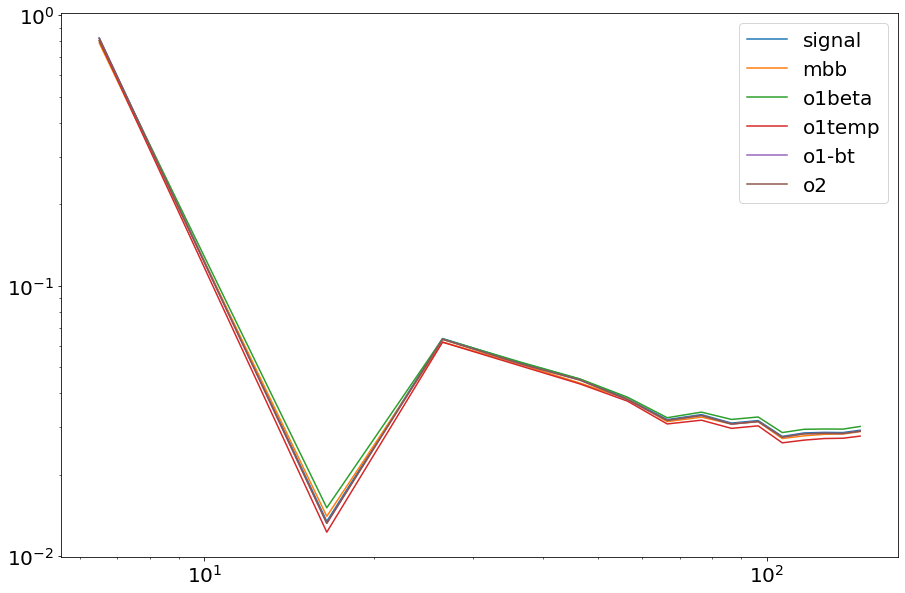

In [40]:
plt.figure(figsize=(15,10))
plt.plot(leff[:Nell],modelBB,label='signal')
plt.plot(leff[:Nell],modelmbb(100,p),label='mbb')
plt.plot(leff[:Nell],modelmomo1beta(100,p),label='o1beta')
plt.plot(leff[:Nell],modelmomo1temp(100,p),label='o1temp')
plt.plot(leff[:Nell],modelmomo1(100,p),label='o1-bt')
plt.plot(leff[:Nell],modelmomo2(100,p),label='o2')
plt.loglog()
plt.legend()

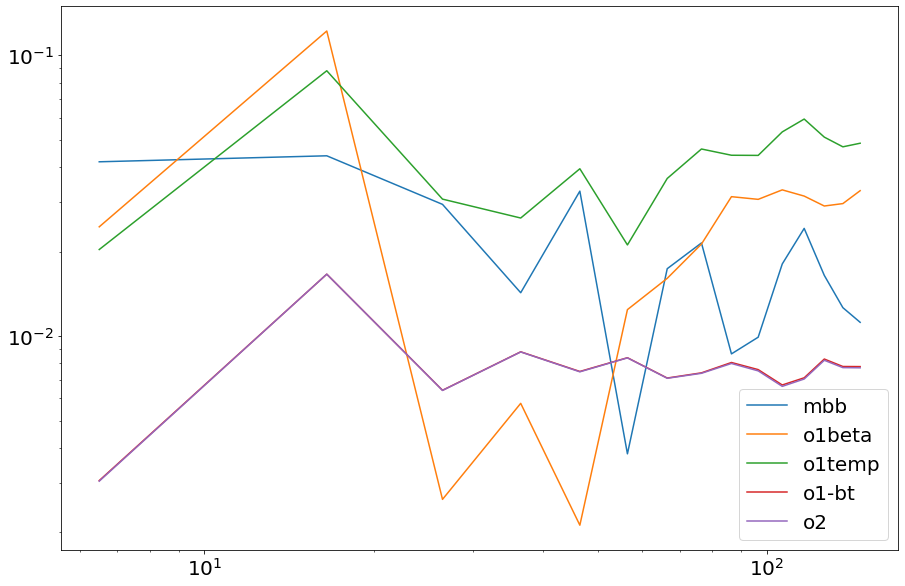

In [46]:
plt.figure(figsize=(15,10))
plt.plot(leff[:Nell],abs(modelBB-modelmbb(100,p))/modelBB,label='mbb')
plt.plot(leff[:Nell],abs(modelBB-modelmomo1beta(100,p))/modelBB,label='o1beta')
plt.plot(leff[:Nell],abs(modelBB-modelmomo1temp(100,p))/modelBB,label='o1temp')
plt.plot(leff[:Nell],abs(modelBB-modelmomo1(100,p))/modelBB,label='o1-bt')
plt.plot(leff[:Nell],abs(modelBB-modelmomo2(100,p))/modelBB,label='o2')
plt.loglog()
plt.legend()

In [ ]:
from astropy import constants as const

pmetbar=1/20
pmetmap=1/tempmap
mom1pmet = skyrefcpxd*(pmetmap-pmetbar)
Aw1p=get_dl_bb_mom(skyrefcpxd,mom1pmet)
w1bw1p=get_dl_bb_mom(mom1b,mom1pmet)
w1pw1p=get_dl_bb_mom(mom1pmet,mom1pmet)
Asw1p= get_dl_bb_mom(skyrefcpxs,mom1pmet)
p2=[Ad[:Nell], betabar*np.ones(Nell),pmetbar*np.ones(Nell),As[:Nell],betasbar*np.ones(Nell),Asd[:Nell]/np.sqrt(As[:Nell]*Ad[:Nell]),Aw1b[:Nell],w1bw1b[:Nell],Aw1p[:Nell],w1bw1p[:Nell],w1pw1p[:Nell],Asw1b[:Nell],Asw1p[:Nell], Aw2b[:Nell], w1bw2b[:Nell], w2bw2b[:Nell]]


In [47]:

def dmbbb_T(nu,b_T):
    x = const.h.value*nu*1.e9/const.k_B.value
    return -x*np.exp(x*b_T)/np.expm1(x*b_T)

def modelmomo1pmet(nu,p):
    nu_i=nu
    nu_j=nu
    nuref=353
    nurefs=23
    ampl = func.mbb_uK(nu_i,p[1],1/p[2])*func.mbb_uK(nu_j,p[1],1/p[2])
    sync= p[3]*func.PL_uK(nu_i,p[4])*func.PL_uK(nu_j,p[4])
    normcorr= np.sqrt(abs(p[0]*p[3]))
    crossdustsync= p[5]*normcorr*(func.mbb_uK(nu_i,p[1],1/p[2])*func.PL_uK(nu_j,p[4])+ func.PL_uK(nu_i,p[4])*func.mbb_uK(nu_j,p[1],1/p[2]))#/(func.PL_uK(nurefs,p[4])*func.mbb_uK(nuref,p[1],p[2]))
    dx0 = dmbbb_T(nuref,p[2])
    dxi = dmbbb_T(nu_i,p[2])
    dxj = dmbbb_T(nu_j,p[2])
    temp = ampl * p[0]
    temp2 = ampl*((dxi+dxj-2*dx0)*p[8]+(dxi-dx0)*(dxj-dx0)*p[10])
    crossdustsync3 = p[12]*(func.mbb_uK(nu_i,p[1],1/p[2],nu0=nuref)*(dxi-dx0)*func.PL_uK(nu_j,p[4],nu0=nurefs)+ func.PL_uK(nu_i,p[4],nu0=nurefs)*func.mbb_uK(nu_j,p[1],1/p[2],nu0=nuref)*(dxj-dx0))
    model = temp + temp2 + sync + crossdustsync + crossdustsync3
    return model

def modelmomo1pmetfull(nu,p):
    nu_i=nu
    nu_j=nu
    nuref=353
    nurefs=23
    ampl = func.mbb_uK(nu_i,p[1],1/p[2])*func.mbb_uK(nu_j,p[1],1/p[2])
    sync= p[3]*func.PL_uK(nu_i,p[4])*func.PL_uK(nu_j,p[4])
    normcorr= np.sqrt(abs(p[0]*p[3]))
    crossdustsync= p[5]*normcorr*(func.mbb_uK(nu_i,p[1],1/p[2])*func.PL_uK(nu_j,p[4])+ func.PL_uK(nu_i,p[4])*func.mbb_uK(nu_j,p[1],1/p[2]))#/(func.PL_uK(nurefs,p[4])*func.mbb_uK(nuref,p[1],p[2]))
    lognui = np.log(nu_i/nuref)
    lognuj = np.log(nu_j/nuref)
    lognuis = np.log(nu_i/nurefs)
    lognujs = np.log(nu_j/nurefs)
    dx0 = dmbbb_T(nuref,p[2])
    dxi = dmbbb_T(nu_i,p[2])
    dxj = dmbbb_T(nu_j,p[2])
    temp = ampl * p[0]
    temp = ampl * (p[0]+ (lognui+lognuj) * p[6]+ lognui*lognuj * p[7])
    temp2 = ampl*((dxi+dxj-2*dx0)*p[8]+(dxi-dx0)*(dxj-dx0)*p[10])
    crossdustsync2 = p[11]*(func.mbb_uK(nu_i,p[1],1/p[2],nu0=nuref)*lognui*func.PL_uK(nu_j,p[4],nu0=nurefs)+ func.PL_uK(nu_i,p[4],nu0=nurefs)*func.mbb_uK(nu_j,p[1],1/p[2],nu0=nuref)*lognuj)
    crossdustsync3 = p[12]*(func.mbb_uK(nu_i,p[1],1/p[2],nu0=nuref)*(dxi-dx0)*func.PL_uK(nu_j,p[4],nu0=nurefs)+ func.PL_uK(nu_i,p[4],nu0=nurefs)*func.mbb_uK(nu_j,p[1],1/p[2],nu0=nuref)*(dxj-dx0))
    model = temp + temp2 + sync + crossdustsync + crossdustsync2 + crossdustsync3
    return model

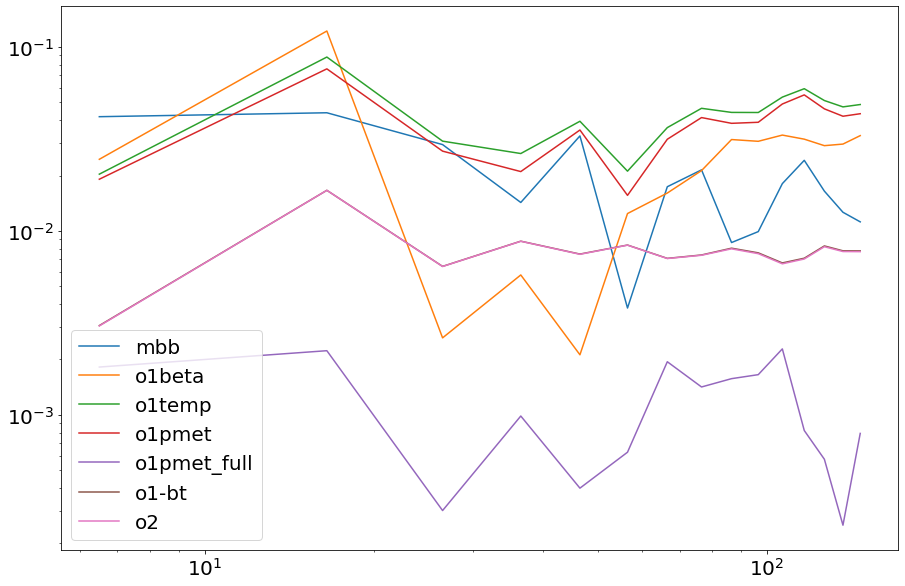

In [48]:
plt.figure(figsize=(15,10))
plt.plot(leff[:Nell],abs(modelBB-modelmbb(100,p))/modelBB,label='mbb')
plt.plot(leff[:Nell],abs(modelBB-modelmomo1beta(100,p))/modelBB,label='o1beta')
plt.plot(leff[:Nell],abs(modelBB-modelmomo1temp(100,p))/modelBB,label='o1temp')
plt.plot(leff[:Nell],abs(modelBB-modelmomo1pmet(100,p2))/modelBB,label='o1pmet')
plt.plot(leff[:Nell],abs(modelBB-modelmomo1pmetfull(100,p2))/modelBB,label='o1pmet_full')
plt.plot(leff[:Nell],abs(modelBB-modelmomo1(100,p))/modelBB,label='o1-bt')
plt.plot(leff[:Nell],abs(modelBB-modelmomo2(100,p))/modelBB,label='o2')
plt.loglog()
plt.legend()